# Predicting House Prices with a Convolutional Neural Network CNN

In this notebook, I will be building a CNN model to predict house prices inspired by Joseph Lee's model [here](https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4). I will be using house price data from [here](https://drive.google.com/file/d/1GfvKA0qznNVknghV4botnNxyH-KvODOC/view). In this project, I'll be providing background of the data, going through data processing (splitting the data into train, validation, and testing). Then, I'll go into building the model. Lastly, I'll look at our predictions and error.

## Loading in the Data and Processing

In preprocessing, we'll be loading in our csv file and starting basic data preprocessing.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/SureStart/Predicting House Prices with CNNs/housepricedata.csv")

In [4]:
df.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,AboveMedianPrice
0,8450,7,5,856,2,1,3,8,0,548,1
1,9600,6,8,1262,2,0,3,6,1,460,1
2,11250,7,5,920,2,1,3,6,1,608,1
3,9550,7,5,756,1,0,3,7,1,642,0
4,14260,8,5,1145,2,1,4,9,1,836,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   LotArea           1460 non-null   int64
 1   OverallQual       1460 non-null   int64
 2   OverallCond       1460 non-null   int64
 3   TotalBsmtSF       1460 non-null   int64
 4   FullBath          1460 non-null   int64
 5   HalfBath          1460 non-null   int64
 6   BedroomAbvGr      1460 non-null   int64
 7   TotRmsAbvGrd      1460 non-null   int64
 8   Fireplaces        1460 non-null   int64
 9   GarageArea        1460 non-null   int64
 10  AboveMedianPrice  1460 non-null   int64
dtypes: int64(11)
memory usage: 125.6 KB


We see the data includes values such as:

- Lot Area (in sq ft)
- Overall Quality (scale from 1 to 10)
- Overall Condition (scale from 1 to 10)
- Total Basement Area (in sq ft)
- Number of Full Bathrooms
- Number of Half Bathrooms
- Number of Bedrooms above ground
- Total Number of Rooms above ground
- Number of Fireplaces
- Garage Area (in sq ft)

We want to <i>predict the last column regarding whether the house is above a median or not</i>. We see, helpfully, this is already encoded as 1 for yes and 0 for no. If this wasn't, we'd have to use an encoding process in our processing.

Now, we'll convert our dataframe into an numpy array. 

In [6]:
dataset = df.values
dataset

array([[ 8450,     7,     5, ...,     0,   548,     1],
       [ 9600,     6,     8, ...,     1,   460,     1],
       [11250,     7,     5, ...,     1,   608,     1],
       ...,
       [ 9042,     7,     9, ...,     2,   252,     1],
       [ 9717,     5,     6, ...,     0,   240,     0],
       [ 9937,     5,     6, ...,     0,   276,     0]])

We can now split our array of arrays into input features (`X`) and what we want to predict (`Y`).

In [7]:
X = dataset[:, :10]
y = dataset[:,10]

In [8]:
print("X")
print(X)
print('\n')
print("Y")
print(y)

X
[[ 8450     7     5 ...     8     0   548]
 [ 9600     6     8 ...     6     1   460]
 [11250     7     5 ...     6     1   608]
 ...
 [ 9042     7     9 ...     9     2   252]
 [ 9717     5     6 ...     5     0   240]
 [ 9937     5     6 ...     6     0   276]]


Y
[1 1 1 ... 1 0 0]


Now, we want to make sure the scale of our input features are similar. Why do we have to do this? We see that some input features are in the thousands, while others are between 1-10. We don't want the nonrelative magnitude to influence our model, so we'll normalize using the `preprocessing` library in the `sklearn` package.

In [9]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [10]:
X_scale

array([[0.0334198 , 0.66666667, 0.5       , ..., 0.5       , 0.        ,
        0.3864598 ],
       [0.03879502, 0.55555556, 0.875     , ..., 0.33333333, 0.33333333,
        0.32440056],
       [0.04650728, 0.66666667, 0.5       , ..., 0.33333333, 0.33333333,
        0.42877292],
       ...,
       [0.03618687, 0.66666667, 1.        , ..., 0.58333333, 0.66666667,
        0.17771509],
       [0.03934189, 0.44444444, 0.625     , ..., 0.25      , 0.        ,
        0.16925247],
       [0.04037019, 0.44444444, 0.625     , ..., 0.33333333, 0.        ,
        0.19464034]])

Now that we've scaled the `X` values, we can move to splitting into a training, validation, and testing set. We need 3 sets in the pipeline, as the validation data lets our model learn better from non-training data. In a ML pipeline, we often:

1. Specify some hyperparameters
2. Train on the training set, which fills in some parameters
3. Record the loss on the validation set
4. Repeat steps 1-3 with different hyperparameters, many times
5. Pick the model with the lowest validation loss as this is now our "best" model
6. Run the chosen model to see error with the testing set

We'll now use `train_test_split` to split our data into a training set and a validation/testing set for both `X` and `y`. Then, we'll further split the validation/testing set into separate sets.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, y, test_size=0.3)

X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [12]:
X_train

array([[0.0132277 , 0.22222222, 0.625     , ..., 0.25      , 0.        ,
        0.        ],
       [0.03563533, 0.66666667, 0.5       , ..., 0.5       , 0.        ,
        0.37165021],
       [0.0438337 , 0.77777778, 0.5       , ..., 0.58333333, 0.33333333,
        0.38152327],
       ...,
       [0.01612564, 0.77777778, 0.5       , ..., 0.25      , 0.33333333,
        0.37940762],
       [0.02675454, 0.44444444, 0.5       , ..., 0.25      , 0.        ,
        0.31734838],
       [0.03514922, 0.44444444, 0.625     , ..., 0.41666667, 0.        ,
        0.32157969]])

In [13]:
Y_train

array([0, 1, 1, ..., 1, 0, 0])

In [14]:
X_test

array([[0.07403772, 0.33333333, 0.625     , ..., 0.33333333, 0.        ,
        0.20028209],
       [0.02196826, 0.44444444, 0.5       , ..., 0.25      , 0.        ,
        0.17630465],
       [0.02757718, 0.55555556, 0.5       , ..., 0.25      , 0.        ,
        0.40338505],
       ...,
       [0.03352263, 0.44444444, 0.5       , ..., 0.25      , 0.        ,
        0.36389281],
       [0.06106242, 0.66666667, 0.5       , ..., 0.41666667, 0.33333333,
        0.32016925],
       [0.03810792, 0.66666667, 0.75      , ..., 0.41666667, 0.        ,
        0.32228491]])

In [15]:
Y_test

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1])

In [16]:
X_val

array([[0.03541564, 0.33333333, 0.5       , ..., 0.33333333, 0.        ,
        0.27926657],
       [0.04499755, 0.77777778, 0.5       , ..., 0.5       , 0.33333333,
        0.5190409 ],
       [0.17669962, 0.66666667, 0.75      , ..., 0.25      , 0.66666667,
        0.30959097],
       ...,
       [0.03133516, 0.77777778, 0.5       , ..., 0.5       , 0.        ,
        0.38928068],
       [0.00638014, 0.44444444, 0.625     , ..., 0.16666667, 0.33333333,
        0.23695346],
       [0.03757975, 0.33333333, 0.625     , ..., 0.16666667, 0.        ,
        0.16502116]])

In [17]:
Y_val

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [18]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(1022, 10) (219, 10) (219, 10) (1022,) (219,) (219,)


Now, we can begin building the actual model

## Building and Training the Convolutional Neural Network

### Setting up Model Architecture

We'll first set up an architecture with defined hidden layers and an output layer. We'll use `Keras` in Tensorflow to help with this by utilizing the `Sequential()` model.

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers

In [20]:
model = Sequential([
    Dense(125, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

Above, I've defined a model architecture with 3 hidden layers layers of 125, 50, and 25 neurons. All have the activation function of `ReLu`. I've defined the input shape for the first layer to `(10,)`, because we have 10 input features in our `X` sets. We recall that `Dense` means a fully-connected layer.

Our last layer utilizes the `sigmoid` activation function with 1 output neuron. We only need 1 output neuron as we are doing binary classification. If we were conducting multi-class classification, we'd need the equivalent number of output neurons to classes.

We also use dropout and l2 regularization to try to prevent overfitting.

### Compiling the Model

Now, we've established the model architecture and now need to find the best numbers for it (parameters) for it to perform well. Before we train, we have to tell the model:

- Which algorithm to use in the optimization
- What loss function we would like to use
- What metrics we want to track apart from the loss

We can do this by <i>compiling</i> the model with the `model.compile()` function.

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

I've specified `adam`, the industry standard for the optimizer, `binary_crossentropy` for the loss function, and asked the model to keep track of `accuracy` in addition to loss.

### Fitting the Model

We can now train the model by calling the `fit` method on the model and specifying parameters such as `batch_size`, number of `epochs`, and the validation set.

I've chosen a batch size of 32 and 100 epochs.

In [22]:
hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
32/32 [==============================] - 3s 13ms/step - loss: 1.7918 - accuracy: 0.5781 - val_loss: 1.4784 - val_accuracy: 0.6164
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 1.3980 - accuracy: 0.6709 - val_loss: 1.1702 - val_accuracy: 0.7900
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 1.1202 - accuracy: 0.7330 - val_loss: 0.9554 - val_accuracy: 0.7580
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 0.9068 - accuracy: 0.7879 - val_loss: 0.7885 - val_accuracy: 0.8082
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.7462 - accuracy: 0.8307 - val_loss: 0.6819 - val_accuracy: 0.8219
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.8518 - val_loss: 0.6199 - val_accuracy: 0.8402
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.5945 - accuracy: 0.8432 - val_loss: 0.5843 - val_accuracy: 0.8447
Epoch 8/100


## Evaluating our Model on the Test Set

Now, after we've trained our model, we can evaluate it on our original test set. 

In [23]:
model_loss = model.evaluate(X_test, Y_test)[0]
model_accuracy = model.evaluate(X_test, Y_test)[1]

print("\n", "The loss of our model is: ", model_loss, "\n")
print("The accuracy of our model is: ", model_accuracy)

7/7 [==============================] - 0s 2ms/step - loss: 0.3097 - accuracy: 0.9178

 The loss of our model is:  0.30974236130714417 

The accuracy of our model is:  0.9178082346916199


## Visualizing Loss and Accuracy

We can visualize loss and accuracy to verify that we are not overfitting. We can do this by using `matplotlib` and utilizing the `.history` attribute of our result when we fit the model `hist`.

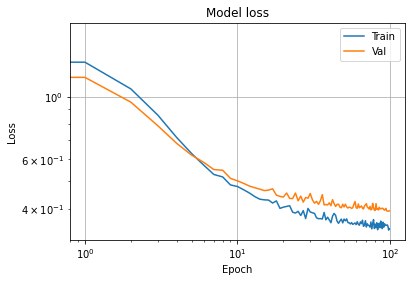

In [28]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.grid()
plt.show()

We can also plot our training and validation accuracy.

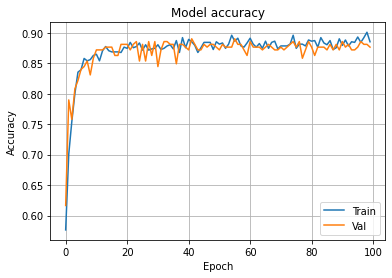

In [26]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.grid()
plt.show()

We see that improvements in the training set seem to match up with improvements with the validation set, so it doesn't seem like overfitting is a very large problem.